In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product               # Cartesian product for iterators
import torch

In [2]:
# Device setting
device = torch.device(0)
print(device)

cuda:0


In [3]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../src/learning')))

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting


In [4]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [5]:
#TestDecoder
# from rewardTransformer import RewardTransformer
state_size = 1
action_size = 1
target_size = 16
hidden_size = 96
stack_size = 100
# target = torch.FloatTensor([[reward]]).to(device)
# print(target)
# model = RewardTransformer(state_size, action_size, target_size, hidden_size, stack_size)
# inputs = (sb[0].T, ab[0].T)
# out = model(inputs, target)
# out = out.squeeze(1)
# print(out)
for i in range(10):
    action_batch = torch.load(f'datafold4x4/reward{i}.pt')
    # print(action_batch)

In [6]:
# Training
from rewardTransformer import RewardTransformer
def Trainer():
    model = RewardTransformer(state_size, action_size, target_size, hidden_size, stack_size)
    loss_fn = torch.nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    losses = []
    for _ in range(10):
        for i in range(9):
            for j in range(6):
                action_batch = torch.load(f'datafold4x4/actions{i}.pt')[j*50:(j+1)*50]
                state_batch = torch.load(f'datafold4x4/states{i}.pt')[j*50:(j+1)*50]
                reward_batch = torch.tensor([[torch.load(f'datafold4x4/reward{i}.pt')]], requires_grad = True, dtype=torch.float32)
                reward_batch = reward_batch.to(device)
                # print(state_batch.requires_grad)
                
                # print(reward_batch.shape)
                action_batch = torch.tensor(action_batch[:, :, None], requires_grad=True).to(device)
                state_batch = torch.tensor(state_batch[:, :, None], requires_grad=True).to(device)
                # action_batch.requires_grad = True
                # state_batch.requires_grad = True
                # print(state_batch.requires_grad)
                # print(reward_batch)
                rew_pred = model((state_batch, action_batch), reward_batch)
                # print(rew_pred)
                loss = loss_fn(reward_batch, rew_pred)
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss)
                # print(loss)
    
    return losses, model
            

losses, model = Trainer()

/home/cleverctz/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/cleverctz/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


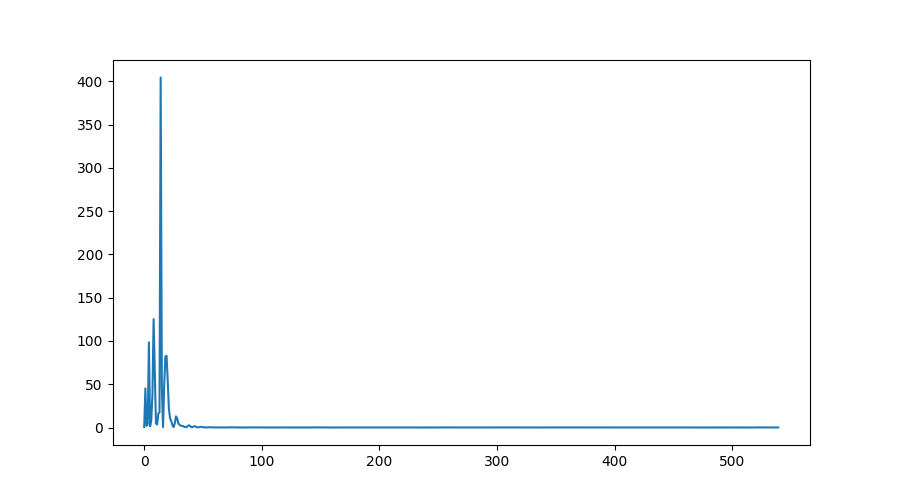

In [12]:
loss_print = [np.array(loss.detach().to('cpu')) for loss in losses]
# print(losses)
plt.figure()
plt.plot(loss_print)
plt.show()

In [13]:
reward_irl = torch.Tensor([[torch.load('datafold4x4/reward9.pt')]]).to(device)
state_test = torch.load('datafold4x4/states9.pt')
action_test = torch.load('datafold4x4/actions9.pt')
reward_pred = model((state_test[:50][:, :, None].to(device), action_test[:50][:, :, None].to(device)), reward_irl)
print(reward_pred)

tensor([[[0.0952, 0.3031, 0.5479, 0.5253, 0.3670, 0.6322, 0.3840, 0.4285,
          0.4498, 0.4840, 0.5335, 0.4233, 0.4401, 0.4580, 0.4201, 1.0746]]],
       device='cuda:0', grad_fn=<PermuteBackward>)


In [14]:
# i = 0
reward_preds = [model((state_test[i*50:(i+1)*50][:, :, None].to(device), action_test[i*50:(i+1)*50][:, :, None].to(device)), reward_irl).detach().to('cpu') for i in range(6)]
l2 = 0
for i in reward_preds:
    l2+=torch.cdist(i, reward_irl.to('cpu'))

l2/=len(reward_preds)
print(l2)

world = W.IcyGridWorld(size=4, p_slip=0.2)
trivial_reward = reward = np.zeros(world.n_states)
trivial_reward[-1] = 1.0
trivial_reward[6] = 0.65

print(np.sum(np.linalg.norm((trivial_reward, np.asarray(reward_irl.to('cpu'))), axis=-1)))


tensor([[[0.5802]]])
8.48128308754093


/home/cleverctz/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/linalg/linalg.py:2514: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asarray(x)


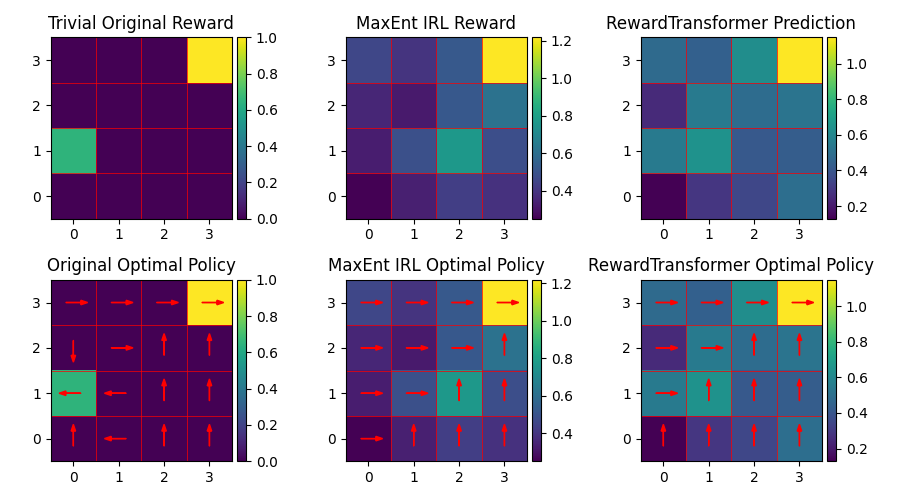

In [ ]:
world = W.IcyGridWorld(size=4, p_slip=0.2)
trivial_reward = reward = np.zeros(world.n_states)
trivial_reward[-1] = 1.0
trivial_reward[4] = 0.65

fig = plt.figure()

ax = fig.add_subplot(231)
ax.title.set_text('Trivial Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, trivial_reward, **style)
fig.colorbar(p, cax=cax)


ax = fig.add_subplot(232)
ax.title.set_text('MaxEnt IRL Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_irl.to('cpu'), **style)
fig.colorbar(p, cax=cax)

# fig = plt.figure()
ax = fig.add_subplot(233)
ax.title.set_text('RewardTransformer Prediction')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_pred.detach().to('cpu'), **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(234)
ax.title.set_text('Original Optimal Policy')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, trivial_reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, trivial_reward, 0.8), color='red')
fig.colorbar(p, cax=cax)

reward_irl = reward_irl.to('cpu').squeeze(0)
reward_irl = reward_irl.to('cpu').squeeze(0)
# print(reward_irl)
reward_irl = np.array(reward_irl)

ax = fig.add_subplot(235)
ax.title.set_text('MaxEnt IRL Optimal Policy')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_irl, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_irl, 0.8), color='red')
fig.colorbar(p, cax=cax)

# print(reward_pred.shape)
reward_pred = reward_pred.detach().to('cpu').squeeze(0)
reward_pred = reward_pred.to('cpu').squeeze(0)
# print(reward_irl)
reward_pred = np.array(reward_pred)

ax = fig.add_subplot(236)
ax.title.set_text('RewardTransformer Optimal Policy')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_pred, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_pred, 0.8), color='red')
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()